In [ ]:
!pip install liac-arff joblib


  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=c5e0ac1877bc584c241f71504c5cca1e5d5e9b3da896ae22b6d72ad3f2be7f04
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [ ]:
import urllib.request
import arff
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

zip_path = list(uploaded.keys())[0]  # Automatically uses the uploaded file
extract_folder = "autism_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extracted files:", os.listdir(extract_folder))


Saving autistic+spectrum+disorder+screening+data+for+children.zip to autistic+spectrum+disorder+screening+data+for+children.zip
Extracted files: ['Autism-Child-Data.arff', 'Autism-Screening-Child-Data Description.docx']


In [ ]:
arff_file = os.path.join(extract_folder, "Autism-Child-Data.arff")  # Adjust if name is different

with open(arff_file, "r") as f:
    data = arff.load(f)

df = pd.DataFrame(data['data'], columns=[attr[0].strip() for attr in data['attributes']])
print(df.head())

# Drop non-essential columns
df.drop(['age_desc'], axis=1, errors='ignore', inplace=True)
df.drop(['result numeric'], axis=1, errors='ignore', inplace=True)
df.drop(['austim'], axis=1, errors='ignore', inplace=True)

# Handle missing values
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Convert target labels ('YES' -> 1, 'NO' -> 0)
df['Class/ASD'] = df['Class/ASD'].str.strip().map({'YES': 1, 'NO': 0}).astype(int)
y = df['Class/ASD']  # Save target before dropping

# Apply T-Int Encoding for categorical features
categorical_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'relation']
t_int_encodings = {}

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        means = df.groupby(col)['Class/ASD'].mean().copy()
        df[col] = df[col].map(means)
        t_int_encodings[col] = means
    else:
        print(f"Warning: Column {col} not found in dataset")

df.drop(columns=['Class/ASD'], inplace=True)  # Drop target column after encoding


  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        1        1        0        0        1        1        0        1   
1        1        1        0        0        1        1        0        1   
2        1        1        0        0        0        1        1        1   
3        0        1        0        0        1        1        0        0   
4        1        1        1        1        1        1        1        1   

  A9_Score A10_Score  ...  gender        ethnicity jundice austim  \
0        0         0  ...       m           Others      no     no   
1        0         0  ...       m  Middle Eastern       no     no   
2        0         0  ...       m             None      no     no   
3        0         1  ...       f             None     yes     no   
4        1         1  ...       m           Others     yes     no   

   contry_of_res used_app_before result    age_desc relation Class/ASD  
0         Jordan              no    5.0  4-11 yea

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Split data (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (148, 18)
Validation data shape: (50, 18)
Test data shape: (50, 18)


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, GaussianNoise, LeakyReLU

model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    GaussianNoise(0.1),  # adds noise to input

    Dense(64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),

    Dense(16, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


In [ ]:
# Train the model
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.4351 - loss: 1.8112 - val_accuracy: 0.4800 - val_loss: 1.6428 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4712 - loss: 1.7893 - val_accuracy: 0.4800 - val_loss: 1.6134 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5402 - loss: 1.7928 - val_accuracy: 0.5600 - val_loss: 1.5855 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5789 - loss: 1.6058 - val_accuracy: 0.6200 - val_loss: 1.5591 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5987 - loss: 1.6656 - val_accuracy: 0.7400 - val_loss: 1.5355 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5895 - loss: 1.6370 - val_accuracy: 0.7600 - val_loss: 1.5138 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6951 - loss: 1.5142 - val_accuracy:

In [ ]:
# Evaluate model on validation set
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
Validation Metrics:
Accuracy: 0.9800
Precision: 0.9600
Recall: 1.0000
F1 Score: 0.9796


In [ ]:
#Evaluate model on test set
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Test Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


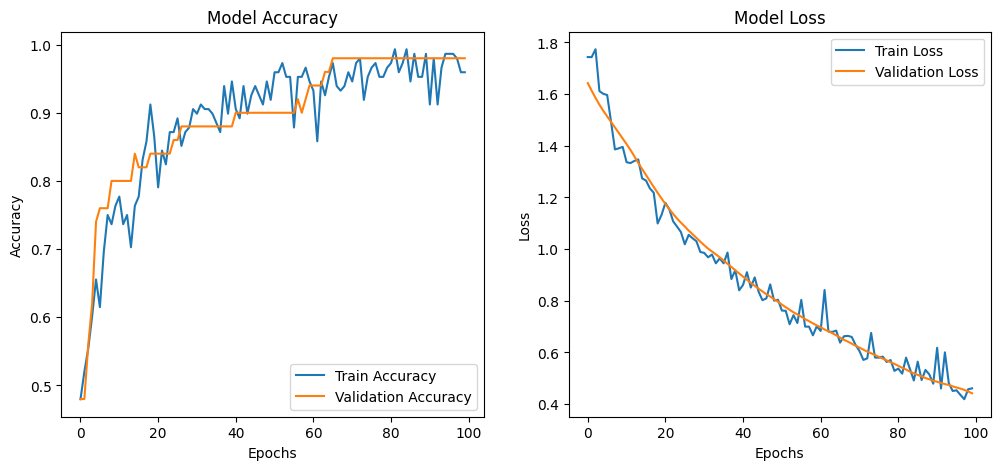

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [ ]:
# Save model, scaler, and encodings
model.save("autism_model.h5")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(t_int_encodings, "t_int_encodings.pkl")
print("Model, scaler, and encodings saved successfully!")


Model, scaler, and encodings saved successfully!


In [ ]:
# Access training accuracy history
train_accuracy = history.history['accuracy']

# Display the training accuracy for each epoch
print("Training accuracy per epoch:", train_accuracy)


Training accuracy per epoch: [0.4797297418117523, 0.5202702879905701, 0.5540540814399719, 0.6013513803482056, 0.6554054021835327, 0.6148648858070374, 0.6959459185600281, 0.75, 0.7364864945411682, 0.7635135054588318, 0.7770270109176636, 0.7364864945411682, 0.75, 0.7027027010917664, 0.7635135054588318, 0.7770270109176636, 0.8310810923576355, 0.8581081032752991, 0.912162184715271, 0.8648648858070374, 0.7905405163764954, 0.8445945978164673, 0.8243243098258972, 0.8716216087341309, 0.8716216087341309, 0.8918918967247009, 0.8513513803482056, 0.8716216087341309, 0.8783783912658691, 0.9054054021835327, 0.8986486196517944, 0.912162184715271, 0.9054054021835327, 0.9054054021835327, 0.8986486196517944, 0.8851351141929626, 0.8716216087341309, 0.9391891956329346, 0.8986486196517944, 0.9459459185600281, 0.9054054021835327, 0.8918918967247009, 0.9391891956329346, 0.8986486196517944, 0.9256756901741028, 0.9391891956329346, 0.9256756901741028, 0.912162184715271, 0.9459459185600281, 0.9189189076423645, 0